# Notebook to evalutate HPC Trained Network #



Load all needed modules

In [1]:
# Imports
import pandas as pd
import random                        # for generating random numbers
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt      # MATLAB like plotting routines
from sklearn.preprocessing import normalize
import math

import json

Load and preprocess Training Data

In [2]:
def preprocess_data(filename):
    # reading csv file
    dataFrameInput = pd.read_csv(filename) #outputs a dataframe object

    idx = 0
    xDataList = list()
    yDataList = list()
    data = dataFrameInput.values  # numpy array

    ## Somehow t = 0 has an odd number of elements, just cut it out

    for row in data:
        if (row[2] > 0):
            if (idx % 2 == 0):
                xDataList.append(row)
            else:
                yDataList.append(row)

            idx = idx + 1

    # merge the lists
    DataList = list()
    for rowX, rowY in zip(xDataList, yDataList):
        DataList.append([rowX, rowY])

    # Shuffle data

    random.shuffle(DataList)

    DataArray = np.asarray(DataList)
    #print(DataArray.shape)

    # Strip off header information, i.e. the first 3 cols
    DataArraySlim = DataArray[:, :, 3:]
    #print(DataArraySlim.shape)

    '''
    # split in train and test data (ratio 4:1)
    DataTrain = DataArraySlim[:4 * int(DataArraySlim.shape[0] / 5)]
    DataTest = DataArraySlim[4 * int(DataArraySlim.shape[0] / 5):]

    # Split in x (input) and y (output) data
    xDataTrain = DataTrain[:, 0, :]
    yDataTrain = DataTrain[:, 1, :]
    xDataTest = DataTest[:, 0, :]
    yDataTest = DataTest[:, 1, :]

    #Normalize Input
    #xDataTrain = normalize(xDataTrain, axis=1, norm='l1')
    #xDataTest = normalize(xDataTest, axis=1, norm='l1')
    
    '''
    
    return DataArraySlim

def split_data(Data, ratio): # 0<ratio<1 ratio of test data
    
    # split in train and test data (ratio 4:1)
    DataTrain = Data[:int((1-ratio)* int(Data.shape[0] ))]
    DataTest = Data[int((1-ratio)* int(Data.shape[0] )):]

    # Split in x (input) and y (output) data
    xDataTrain = DataTrain[:, 0, :]
    yDataTrain = DataTrain[:, 1, :]
    xDataTest = DataTest[:, 0, :]
    yDataTest = DataTest[:, 1, :]
    
    return (xDataTrain,yDataTrain,xDataTest,yDataTest)


Review Training Data

In [3]:
# Load the Data
(xDataTrain,yDataTrain,xDataTest,yDataTest) = split_data(preprocess_data("trainNN.csv"),0.2) 


## Take two: A more sophisticated Loss Function ##

The Loss is defined as the Objective function of the minimal entropy problem:

$L(u,\alpha, \theta) = <\eta_*(\alpha(\theta) \cdot m(v))>_v - \alpha(\theta) \cdot u$





#### Easiest case 
$\alpha, u\in\mathbb{R}$

Entropy $\eta(\alpha\cdot m) = exp(\alpha\cdot m)$ 

Spherical harmonics basis for $M_0$: $ m_0 = \sqrt{\left(\frac{1}{4\pi}\right)}$

tf.Tensor(37.846815845621244, shape=(), dtype=float64)


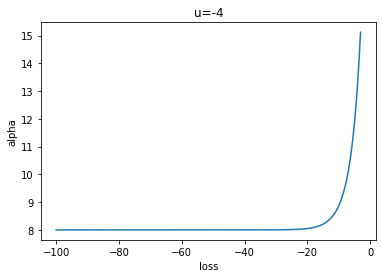

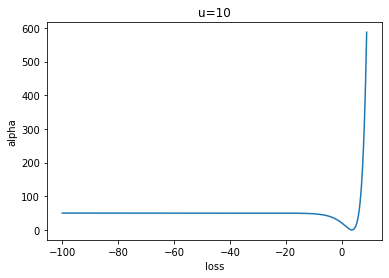

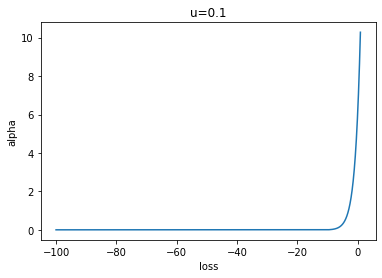

In [4]:
# Custom Loss
def custom_loss1dQuad_eval(u_input, alpha_pred): # (label,prediciton)
     return (0.5*alpha_pred*alpha_pred -u*alpha_pred)

def custom_loss1dMB_eval(u_input, alpha_pred): # (label,prediciton)
    return 4*math.pi*tf.math.exp(alpha_pred*np.sqrt(1/(4*np.pi))) - alpha_pred*u_input
  
# Custom Loss
def custom_loss1dMBPrime_eval(u_input, alpha_pred): # (label,prediciton)
    return 0.5*tf.square(4*math.pi*np.sqrt(1/(4*np.pi))*tf.math.exp(alpha_pred*np.sqrt(1/(4*np.pi))) - u_input)


# not realizable moment
u = -4
print(custom_loss1dMBPrime_eval(u,1))

alpha = np.arange(-100.0, -3, 0.05)
plt.figure()
plt.plot(alpha,custom_loss1dMBPrime_eval(u,alpha))
plt.ylabel('alpha')
plt.xlabel('loss')
plt.title('u=-4')
plt.show()

#realizable moment
u = 10
alpha = np.arange(-100.0, 9.0, 0.05)
plt.figure()
plt.plot(alpha,custom_loss1dMBPrime_eval(u,alpha))
plt.ylabel('alpha')
plt.xlabel('loss')
plt.title('u=10')
plt.show()

# moment close to the boundary of the realizable set
u = 0.1
alpha = np.arange(-100.0, 1.0, 0.05)
plt.figure()
plt.plot(alpha,custom_loss1dMBPrime_eval(u,alpha))
plt.ylabel('alpha')
plt.xlabel('loss')
plt.title('u=0.1')
plt.show()

In [5]:
# build the network
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

# Custom Losses for the network

def custom_loss1dMB(): # (label,prediciton)
    def loss(u_input, alpha_pred):
        return 4*math.pi*tf.math.exp(alpha_pred*np.sqrt(1/(4*np.pi))) - alpha_pred*u_input
    return loss

def custom_loss1dMBPrime(): # (label,prediciton)
    def loss(u_input, alpha_pred):
        return 0.5*tf.square(4*math.pi*np.sqrt(1/(4*np.pi))*tf.math.exp(alpha_pred*np.sqrt(1/(4*np.pi))) - u_input)
    return loss

# Custom Loss
def custom_loss1dQuad(): # (label,prediciton)
    def loss(u_input, alpha_pred):
        return (0.5*alpha_pred*alpha_pred -u*alpha_pred)
    return loss


# Build the network: (for reference)
def create_model():
    
    # Define the input
    input_ = keras.Input(shape=(1,))
    
    # Hidden layers
    hidden1 = layers.Dense(4, activation="tanh")(input_)  
    hidden2 = layers.Dense(8, activation="tanh")(hidden1)  
    hidden3 = layers.Dense(32, activation="tanh")(hidden2)  
    hidden4 = layers.Dense(8, activation="tanh")(hidden3)  
    hidden5 = layers.Dense(4, activation="tanh")(hidden4)  
    
    #Define the ouput
    output_ = layers.Dense(1)(hidden5)
    
    # Create the model
    model = keras.Model(inputs=[input_], outputs=[output_] )
    
    
    model.summary()
    
    # tf.keras.losses.MeanSquaredError()
    #custom_loss1d
    model.compile(loss=custom_loss1dMBPrime() , optimizer='adam') #, metrics=[custom_loss1dMB, custom_loss1dMBPrime()])

    return model


### Study of Optimizers ###

Use the dataset np.arange(0.1, 2,0.000001)
* RMSPROP: minimal Loss  4.8240e-05  in 79 epochs
* ADAM:    minimal Loss  1.2580e-06 in 68 epochs
* SGD:  minimal Loss 6.9069e-05 in 167 epochs


### Load trained Network ###
Trained from HPC cluster and review training history

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_2 (Dense)              (None, 32)                288       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

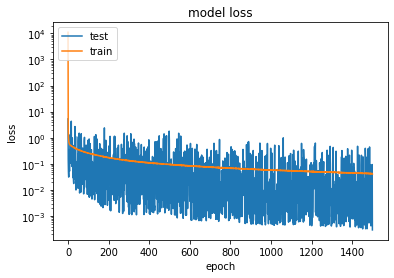

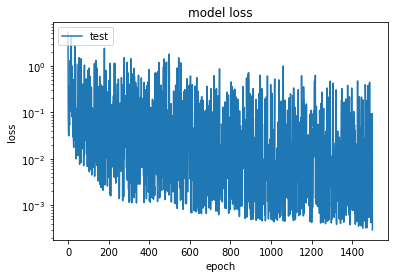

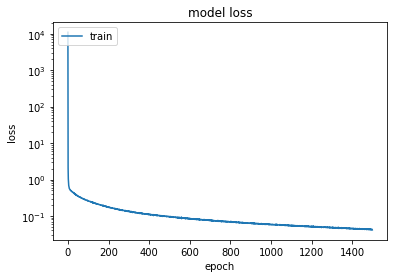

In [6]:
# load pre-trained model 
model = tf.keras.models.load_model('saved_model_GPU/_EntropyLoss_1_300_M_0', custom_objects={ 'loss':custom_loss1dMBPrime })

# Check its architecture
model.summary()

with open('saved_model_GPU/_EntropyLoss_1_300_M_0_hist.json') as json_file:
    history1 = json.load(json_file)

plt.plot(history1['val_loss'])
plt.plot(history1['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['test', 'train'], loc='upper left')
plt.show()

plt.plot(history1['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['test'], loc='upper left')
plt.show()

plt.plot(history1['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train'], loc='upper left')
plt.show()

## Test the model ##

[[-4.7419214]]


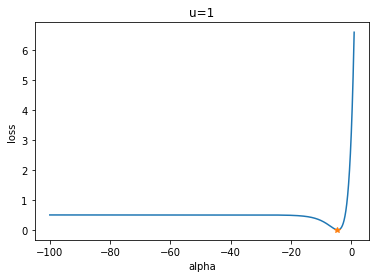

[[-3.1162605]]


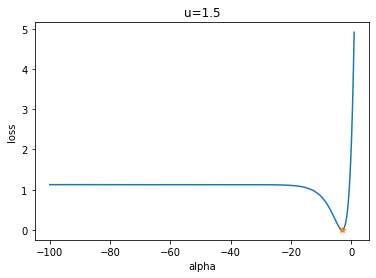

[[11.838796]]


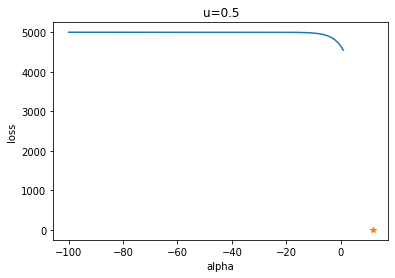

In [7]:
# make prediction
pred = model.predict([1])
print(pred)
# plot prediction to minimal entropy
u = 1
alpha = np.arange(-100.0, 1.0, 0.05)
plt.figure()
plt.plot(alpha,custom_loss1dMBPrime_eval(u,alpha))
plt.plot(pred,custom_loss1dMBPrime_eval(u,pred), marker="*")
plt.xlabel('alpha')
plt.ylabel('loss')
plt.title('u=1')
plt.show()
# plot prediction to minimal entropy
u = 1.5
pred = model.predict([u])
print(pred)
alpha = np.arange(-100.0, 1.0, 0.05)
plt.figure()
plt.plot(alpha,custom_loss1dMBPrime_eval(u,alpha))
plt.plot(pred,custom_loss1dMBPrime_eval(u,pred), marker="*")
plt.xlabel('alpha')
plt.ylabel('loss')
plt.title('u=1.5')
plt.show()

u = 100
pred = model.predict([u])
print(pred)
alpha = np.arange(-100.0, 1.0, 0.05)
plt.figure()
plt.plot(alpha,custom_loss1dMBPrime_eval(u,alpha))
plt.plot(pred,custom_loss1dMBPrime_eval(u,pred), marker="*")
plt.xlabel('alpha')
plt.ylabel('loss')
plt.title('u=0.5')
plt.show()

(312354, 1)
(312354, 1)
(0, 1)
(0, 1)
[9.76142e-05 9.76142e-05 9.76142e-05 ... 9.76142e-05 9.76142e-05
 9.76142e-05]


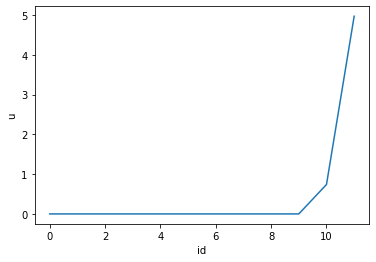

(4,)


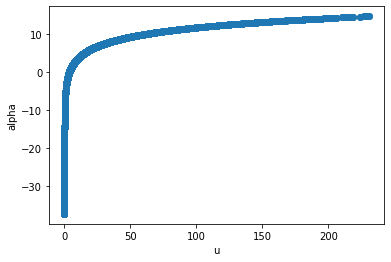

(312354, 1)


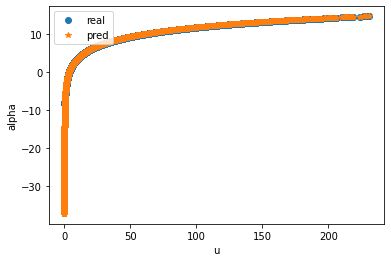

In [8]:
(xDataTrain,yDataTrain,xDataTest,yDataTest)=split_data(preprocess_data("testSetM_0.csv"),0.0)

#Check Test Data
print(xDataTrain.shape)
print(yDataTrain.shape)
print(xDataTest.shape)
print(yDataTest.shape)

print(xDataTrain[:,0])
plt.figure()
plt.plot(xDataTrain[:12])
plt.xlabel('id')
plt.ylabel('u')
plt.show()

x = np.array([1,2,4,5])
y = np.array([1,0,1,0])
print(x.shape)
plt.figure()
plt.plot(xDataTrain[:,0],yDataTrain[:,0], 'o')
plt.xlabel('u')
plt.ylabel('alpha')
plt.show()



#score = model.evaluate(np.asarray(xDataTrain), np.asarray(xDataTrain))
#print('Test score:', score[0])
#print('Test accuracy:', score[1])


pred = model.predict(np.asarray(xDataTrain))
print(pred.shape)

plt.figure()
plt.plot(xDataTrain[:,0],pred[:,0], 'o')
plt.plot(xDataTrain[:,0],yDataTrain[:,0], '*')
plt.xlabel('u')
plt.ylabel('alpha')
plt.legend(['real', 'pred'], loc='upper left')
plt.show()

#### The more complicated case ###